In [1]:
import json
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import os
import pickle
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier,BaggingClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, chi2, RFECV
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC, LinearSVC, SVR

C:\Users\oswal\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\oswal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
trainData = pd.read_csv('data/petfinder/train.csv')

In [4]:
trainData.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64


<AxesSubplot:>

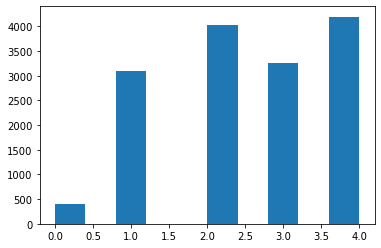

In [5]:
# Adoption speed label
print(trainData['AdoptionSpeed'].value_counts())
trainData['AdoptionSpeed'].hist(grid = False)

In [6]:
print("Total number of pets: ", len(trainData))
print("Total number of unnamed pets: ", sum(trainData['Name'].isna()))

Total number of pets:  14993
Total number of unnamed pets:  1257


In [7]:
trainData.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [8]:
# Convert description column to string.
trainData['Description'] = trainData['Description'].astype('string')

# Replace N/A by empty string.
trainData['Description'] = trainData['Description'].fillna ("")

# Add HasDescription column.
trainData['HasDescription'] = trainData['Description'] != ""

# Add DescriptionLength column.
trainData['DescriptionLength'] = [len(x) for x in trainData['Description']]

In [9]:
# Adding sentiment features for description.

# Get sentiment dataframe.
def get_description_sentiment_dataframe():

    ids = []
    sentiment_magnitudes = []
    sentiment_scores = []
    
    path = 'data/petfinder/train_sentiment'
    fileList = os.listdir(path)
    
    for filename in fileList:
        file = open(os.path.join(path + '/' + filename), 'r', encoding="utf8")
        
        sentiment = json.load(file)
        
        id = filename.split(".")[0]
        sentiment_magnitude = float(sentiment['documentSentiment']['magnitude'])
        sentiment_score = float(sentiment['documentSentiment']['score'])
        
        ids.append(id)
        sentiment_magnitudes.append(sentiment_magnitude)
        sentiment_scores.append(sentiment_score)
        
    d = {"id": ids, "sentiment_magnitude": sentiment_magnitudes, "sentiment_score": sentiment_scores }
    df = pd.DataFrame(d)
    
    return df
        
sentiment_df = get_description_sentiment_dataframe()
sentiment_df.head(10)

,id,sentiment_magnitude,sentiment_score
0,0008c5398,2.8,0.7
1,000a290e4,0.6,0.3
2,000fb9572,0.8,0.3
3,0011d7c25,0.8,0.8
4,00156db4a,1.8,0.0
5,001a1aaad,3.5,0.2
6,001b1507c,4.7,0.3
7,002230dea,2.0,0.4
8,002278114,11.4,0.1
9,0038234c6,3.0,0.3


In [10]:
# Merging sentiment dataframe with main dataframe.
trainData = trainData.merge(sentiment_df, left_on='PetID', right_on='id', how='left')

In [11]:
# Adding sentiment product: (sentiment * magnitude) as a feature to dataframe.
trainData['SentimentProduct'] = trainData['sentiment_score']*trainData['sentiment_magnitude']

In [12]:
# Computing sentiment using NLTK's pre-trained analyzer.

def get_description_nltk_sentiment_analysis_dataframe():
    sia = SentimentIntensityAnalyzer()
    ids = trainData['PetID']
    descriptions = trainData['Description']
    
    negative_probs = []
    neutral_probs = []
    positive_probs = []
    compound_scores = []
    
    for description in descriptions:
        polarity_scores = sia.polarity_scores(description)
        
        negative_probs.append(polarity_scores['neg'])
        neutral_probs.append(polarity_scores['neu'])
        positive_probs.append(polarity_scores['pos'])
        compound_scores.append(polarity_scores['compound'])
    
    d = { "PetID": ids, "nltk_negative_prob": negative_probs, "nltk_neutral_prob": neutral_probs, \
          "nltk_positive_prob" : positive_probs, 'nltk_compound_score' : compound_scores}
    df = pd.DataFrame(d)
    
    return df
        
nltk_sentiment_df = get_description_nltk_sentiment_analysis_dataframe()

In [13]:
# Merge train dataframe with NLTK sentiment dataframe.
trainData = trainData.merge(nltk_sentiment_df, on='PetID', how='left')

trainData.head(10)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,HasDescription,DescriptionLength,id,sentiment_magnitude,sentiment_score,SentimentProduct,nltk_negative_prob,nltk_neutral_prob,nltk_positive_prob,nltk_compound_score
0,2,Nibble,3,299,0,1,1,7,0,1,...,True,359,86e1089a3,2.4,0.3,0.72,0.000,0.745,0.255,0.9552
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,True,118,6296e909a,0.7,-0.2,-0.14,0.149,0.723,0.129,0.1280
2,1,Brisco,1,307,0,1,2,7,0,2,...,True,393,3422e4906,3.7,0.2,0.74,0.095,0.706,0.200,0.7650
3,1,Miko,4,307,0,2,1,2,0,2,...,True,146,5842f1ff5,0.9,0.9,0.81,0.000,0.483,0.517,0.9538
4,1,Hunter,1,307,0,1,1,0,0,2,...,True,390,850a43f90,3.7,0.6,2.22,0.000,0.635,0.365,0.9880
5,2,NaN,3,266,0,2,5,6,0,2,...,True,87,d24c30b4b,0.2,0.0,0.00,0.000,1.000,0.000,0.0000
6,2,BULAT,12,264,264,1,1,0,0,2,...,True,400,1caa6fcdb,0.5,0.2,0.10,0.000,0.814,0.186,0.9116
7,1,Siu Pak & Her 6 Puppies,0,307,0,2,1,2,7,2,...,True,109,97aa9eeac,0.9,0.1,0.09,0.000,0.818,0.182,0.4588
8,2,NaN,2,265,0,2,6,0,0,2,...,True,79,c06d167ca,0.5,0.1,0.05,0.113,0.576,0.311,0.5327
9,2,Kitty,12,265,0,2,1,7,0,2,...,True,232,7a0942d61,1.1,0.2,0.22,0.000,0.751,0.249,0.8916


In [14]:
# Merge train dataset with laplacian variance dataframe.
laplacian_df = pd.read_csv('data/petfinder/laplacian_variance.csv')
trainData = trainData.merge(laplacian_df, on='PetID', how='left')

trainData.head(10)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,sentiment_score,SentimentProduct,nltk_negative_prob,nltk_neutral_prob,nltk_positive_prob,nltk_compound_score,FirstLaPlacianVariance,AvgLaPlacianVariance,MinLaPlacianVariance,MaxLaPlacianVariance
0,2,Nibble,3,299,0,1,1,7,0,1,...,0.3,0.72,0.000,0.745,0.255,0.9552,672.771047,672.771047,672.771047,672.771047
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,-0.2,-0.14,0.149,0.723,0.129,0.1280,454.006659,332.307966,210.609272,454.006659
2,1,Brisco,1,307,0,1,2,7,0,2,...,0.2,0.74,0.095,0.706,0.200,0.7650,60.519822,398.978193,60.519822,1817.619512
3,1,Miko,4,307,0,2,1,2,0,2,...,0.9,0.81,0.000,0.483,0.517,0.9538,502.303825,415.445988,202.183457,555.339070
4,1,Hunter,1,307,0,1,1,0,0,2,...,0.6,2.22,0.000,0.635,0.365,0.9880,363.978801,286.989994,211.482662,363.978801
5,2,NaN,3,266,0,2,5,6,0,2,...,0.0,0.00,0.000,1.000,0.000,0.0000,809.205467,861.569106,809.205467,913.932746
6,2,BULAT,12,264,264,1,1,0,0,2,...,0.2,0.10,0.000,0.814,0.186,0.9116,132.502040,119.836695,62.306946,164.701098
7,1,Siu Pak & Her 6 Puppies,0,307,0,2,1,2,7,2,...,0.1,0.09,0.000,0.818,0.182,0.4588,24.170614,32.903194,23.660589,81.052534
8,2,NaN,2,265,0,2,6,0,0,2,...,0.1,0.05,0.113,0.576,0.311,0.5327,79.577436,427.086163,79.577436,896.854879
9,2,Kitty,12,265,0,2,1,7,0,2,...,0.2,0.22,0.000,0.751,0.249,0.8916,130.861890,260.147623,130.861890,389.433356


In [15]:
# Merge train dataset with laplacian variance dataframe.
confidence_converage_df = pd.read_csv('data/img_coverage_conf.csv')
trainData = trainData.merge(confidence_converage_df, left_on='PetID', right_on='filename', how='left')

trainData.head(10)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,nltk_compound_score,FirstLaPlacianVariance,AvgLaPlacianVariance,MinLaPlacianVariance,MaxLaPlacianVariance,Unnamed: 0,Unnamed: 0.1,filename,confidence,coverage
0,2,Nibble,3,299,0,1,1,7,0,1,...,0.9552,672.771047,672.771047,672.771047,672.771047,11596.0,7596.0,86e1089a3,0.891234,10.053241
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,0.1280,454.006659,332.307966,210.609272,454.006659,11313.0,7313.0,6296e909a,0.846251,68.934937
2,1,Brisco,1,307,0,1,2,7,0,2,...,0.7650,60.519822,398.978193,60.519822,1817.619512,9023.0,5023.0,3422e4906,0.993825,80.775000
3,1,Miko,4,307,0,2,1,2,0,2,...,0.9538,502.303825,415.445988,202.183457,555.339070,125.0,125.0,5842f1ff5,0.989233,77.653333
4,1,Hunter,1,307,0,1,1,0,0,2,...,0.9880,363.978801,286.989994,211.482662,363.978801,2559.0,2559.0,850a43f90,0.989775,30.327869
5,2,NaN,3,266,0,2,5,6,0,2,...,0.0000,809.205467,861.569106,809.205467,913.932746,54800.0,12800.0,d24c30b4b,0.998554,34.859375
6,2,BULAT,12,264,264,1,1,0,0,2,...,0.9116,132.502040,119.836695,62.306946,164.701098,8166.0,4166.0,1caa6fcdb,0.996223,44.998333
7,1,Siu Pak & Her 6 Puppies,0,307,0,2,1,2,7,2,...,0.4588,24.170614,32.903194,23.660589,81.052534,11144.0,7144.0,97aa9eeac,0.000000,0.000000
8,2,NaN,2,265,0,2,6,0,0,2,...,0.5327,79.577436,427.086163,79.577436,896.854879,87.0,87.0,c06d167ca,0.991979,64.423333
9,2,Kitty,12,265,0,2,1,7,0,2,...,0.8916,130.861890,260.147623,130.861890,389.433356,3755.0,3755.0,7a0942d61,0.951346,74.375000


In [16]:
trainData["confidence"].fillna(0, inplace = True)
trainData["coverage"].fillna(0, inplace = True)

In [17]:
trainData.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'HasDescription', 'DescriptionLength', 'id', 'sentiment_magnitude',
       'sentiment_score', 'SentimentProduct', 'nltk_negative_prob',
       'nltk_neutral_prob', 'nltk_positive_prob', 'nltk_compound_score',
       'FirstLaPlacianVariance', 'AvgLaPlacianVariance',
       'MinLaPlacianVariance', 'MaxLaPlacianVariance', 'Unnamed: 0',
       'Unnamed: 0.1', 'filename', 'confidence', 'coverage'],
      dtype='object')

In [18]:
# Using a t-test to determine if there is a statistically significant difference
# in blurriness of the main profile picture for pets that are adopted versus
# non-adopted pets.
from scipy import stats
adopted_pets = trainData[trainData.AdoptionSpeed != 4]
nonadopted_pets = trainData[trainData.AdoptionSpeed == 4]

stats.ttest_ind(adopted_pets['AvgLaPlacianVariance'].dropna().tolist(), nonadopted_pets['AvgLaPlacianVariance'].dropna().tolist())

Ttest_indResult(statistic=-10.40789017089116, pvalue=2.795699384310256e-25)

In [19]:
# Using a t-test to determine if negative sentiment is statistically significant between adopted and non-adopted pets.
from scipy import stats

stats.ttest_ind(adopted_pets['nltk_negative_prob'].dropna().tolist(), nonadopted_pets['nltk_negative_prob'].dropna().tolist())


Ttest_indResult(statistic=-2.8379393029694686, pvalue=0.004546679073766335)

In [20]:
categoricalFeatures = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', \
                       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', \
                       'Sterilized', 'Health', 'State']#, 'HasDescription']

numericalFeatures = ['Age', 'Quantity', 'Fee', 'VideoAmt',  'PhotoAmt', 'DescriptionLength',\
                    #'sentiment_magnitude', 'sentiment_score', 'SentimentProduct',\
                    'nltk_positive_prob', 'nltk_negative_prob', 'nltk_neutral_prob',\
                    'nltk_compound_score', 'AvgLaPlacianVariance','confidence','coverage']

selectedCategoricalFeatures = ['Breed1', ]
selectedNumericalFeatures = ['Age', 'PhotoAmt', 'DescriptionLength',\
                             'nltk_negative_prob', \
                             'AvgLaPlacianVariance']

features = categoricalFeatures + numericalFeatures
#features = selectedCategoricalFeatures + selectedNumericalFeatures

In [21]:
# Transforming columns.
labelEncoder = sklearn.preprocessing.LabelEncoder()
trainData['AdoptionSpeed'] = labelEncoder.fit_transform(trainData['AdoptionSpeed'])
    
# Transform features into categorical.
for c in selectedCategoricalFeatures:
        trainData[c] = trainData[c].astype('category')
        
# Transform features into float.
for c in selectedNumericalFeatures:
        trainData[c] = trainData[c].astype('float')
        
# Fill N/A values with zero for sentiment
trainData = trainData.fillna(value={'sentiment_magnitude': 1, 'sentiment_score': 1, 'SentimentProduct': 1, 'AvgLaPlacianVariance' : 0})

In [22]:
# Splitting into train and test set.
x_train, x_test, y_train, y_test = train_test_split(trainData[features], trainData['AdoptionSpeed'], \
                                                    test_size=0.33, shuffle=True)

In [23]:
# Training a decision tree classifier for testing.
decisionTree = sklearn.tree.DecisionTreeClassifier(random_state=0)

decisionTree.fit(x_train, y_train)
        
decisionTreePredictions = decisionTree.predict(x_test)

print("F1 Score:", f1_score(y_test, decisionTreePredictions, average='macro'))
print("Accuracy Score:", accuracy_score(y_test, decisionTreePredictions))
print("Recall Score:", recall_score(y_test, decisionTreePredictions, average='macro'))

F1 Score: 0.27531216176162104
Accuracy Score: 0.32356507679870655
Recall Score: 0.2752777588692827


In [24]:
#Function for training a model.
def train_model(feature_selector, model):
    if feature_selector is not None:
        x_train_new = feature_selector.fit_transform(x_train, y_train)
    else:
        x_train_new = x_train
    #trained_model = Pipeline([
        #('feature_selection', SelectFromModel(estimator=sklearn.tree.DecisionTreeClassifier(random_state=0))),
        #('feature_selection', SelectFromModel(LinearSVC())),
        #('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators=50))),
        #('feature_selection', SelectFromModel(sklearn.tree.DecisionTreeClassifier(random_state=0))),
    #    ('feature_selection', SelectFromModel(VarianceThreshold(threshold=(.8 * (1 - .8))).fit_transform(x_train,y_train))),
    #    ('classification', model)
    #])
    #trained_model.fit(x_new, y_train)
    model.fit(x_train_new, y_train)
    
    return model

# Function for training and outputing test results for a model.
def train_and_test_model(feature_selector, model):
    
    trained_model = train_model(feature_selector, model)
    
    if feature_selector is not None:
        x_test_new = feature_selector.transform(x_test)
    else:
        x_test_new = x_test

    predictions = trained_model.predict(x_test_new)
    
    print("F1 Score:", f1_score(y_test, predictions, average='macro'))
    print("Accuracy Score:", accuracy_score(y_test, predictions))
    print("Recall Score:", recall_score(y_test, predictions, average='macro'))
    
    if hasattr(trained_model, 'feature_importances_'):
        print("Feature Importances: ")
        for feature, importance in zip(features, trained_model.feature_importances_):
            print('feature: {f}, importance: {i}'.format(f=feature, i=importance))
    print()
    

# Function for training and outputing test results for a collection of models.
def train_and_test_model_collection(feature_selector, models):
    for model_name, model in models.items():
        print("Training and testing model:", model_name)
        train_and_test_model(feature_selector, model)
        print("=====")

In [25]:
# Training and testing multiple models.
#feature_selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
#feature_selector = SelectKBest(chi2, k=3)
#feature_selector = RFECV(SVR(kernel="linear"), step=1, cv=5)
feature_selector = None

model_collection = { 'Decision Tree' : sklearn.tree.DecisionTreeClassifier(random_state=0), \
                     'Support Vector Machine' : sklearn.svm.SVC(decision_function_shape='ovr'), \
                     'Bernoulli Naive Bayes' : BernoulliNB(), \
                     'Gaussian Naive Bayes' : GaussianNB(), \
                     'Multi-layer Perceptron Classifier' : MLPClassifier(random_state = 0), \
                     'KNN Classifier' : KNeighborsClassifier(n_neighbors=6), \
                     'Bagging Extra Tree Classifier' : BaggingClassifier(ExtraTreeClassifier(random_state=0), random_state=0), \
                     'Random Forest Classifier' : RandomForestClassifier(max_depth=20, random_state=0), \
                     'Gradient Boosting Classifier' : GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, \
                                                                                 max_depth=10, random_state=0), \
                     'Ada Boost Classifier' : AdaBoostClassifier(n_estimators=100, random_state=0),
                     'Bagging Classifier (Decision Trees)' : BaggingClassifier(base_estimator=sklearn.tree.DecisionTreeClassifier(random_state=0), n_estimators=10, random_state=0)}

train_and_test_model_collection(feature_selector, model_collection)

Training and testing model: Decision Tree
F1 Score: 0.27531216176162104
Accuracy Score: 0.32356507679870655
Recall Score: 0.2752777588692827
Feature Importances: 
feature: Type, importance: 0.00033758100721039287
feature: Breed1, importance: 0.04507224928229456
feature: Breed2, importance: 0.02397985947918995
feature: Gender, importance: 0.016473055419409778
feature: Color1, importance: 0.02926308463915204
feature: Color2, importance: 0.030982745790562066
feature: Color3, importance: 0.016374545281794377
feature: MaturitySize, importance: 0.019149364620816907
feature: FurLength, importance: 0.015202006559572953
feature: Vaccinated, importance: 0.012790900813823497
feature: Dewormed, importance: 0.010532591774630635
feature: Sterilized, importance: 0.016212130662293954
feature: Health, importance: 0.005033283808990707
feature: State, importance: 0.02566107531231757
feature: Age, importance: 0.06060981450725061
feature: Quantity, importance: 0.019272953595755836
feature: Fee, importance:

In [26]:
# Utility function for saving a model with pickle.
def save_pickle_model(model_filename, model):
    pickle.dump(model, open(model_filename, 'wb'))

In [27]:
# Save a sample random forest classifier.
save_pickle_model("models/random_forest_classifier_kaggle.pkl", train_model(feature_selector, RandomForestClassifier(max_depth=20, random_state=0)))

In [28]:
# Plotting feature weights for Random Forest Classifier.
random_forest_classifier = RandomForestClassifier(max_depth=20, random_state=0)
trained_random_forest_classifier = train_model(feature_selector = None, model = random_forest_classifier)
print("Feature Importances: ")
for feature, importance in zip(features, trained_random_forest_classifier.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feature, i=importance))

Feature Importances: 
feature: Type, importance: 0.0071687380309141385
feature: Breed1, importance: 0.04432675754952017
feature: Breed2, importance: 0.023694422458863572
feature: Gender, importance: 0.020026284194342586
feature: Color1, importance: 0.03166401369360873
feature: Color2, importance: 0.033076877868953074
feature: Color3, importance: 0.016757495379161068
feature: MaturitySize, importance: 0.017926592140790273
feature: FurLength, importance: 0.01873941623265217
feature: Vaccinated, importance: 0.016552103095524795
feature: Dewormed, importance: 0.016626133003504913
feature: Sterilized, importance: 0.019476328935214143
feature: Health, importance: 0.004113089459349873
feature: State, importance: 0.026058119798708115
feature: Age, importance: 0.06344145080143078
feature: Quantity, importance: 0.020974812859555023
feature: Fee, importance: 0.017402327928797885
feature: VideoAmt, importance: 0.004407677149458165
feature: PhotoAmt, importance: 0.05110465926600821
feature: Descrip

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (22,) and arg 1 with shape (27,).

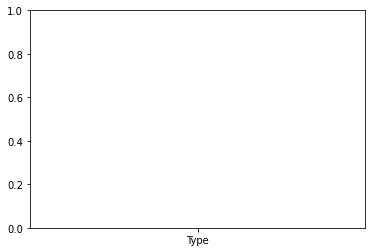

In [29]:
import matplotlib.pyplot as plt
plt.bar(["Type", "Breed 1", "Breed 2", "Gender", "Color 1", "Color 2", "Color 3", "Maturity Size", "Fur Length", "Vaccinated", "Dewormed", "Sterilized", "Health", "State", "Age", "Quantity", "Fee", "Video Amount", "Photo Amount", "Description Length", "Negative Probability", "Average Blurriness"], trained_random_forest_classifier.feature_importances_)
plt.xticks(rotation='vertical')
plt.title("Feature weights for each feature")
plt.show()

In [ ]:
# Detecting blurriness in images.
#!pip install opencv-python
import cv2
from IPython.display import Image, display

def variance_of_laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [30]:
imagePath = "data/images/0008c5398-1.jpg"
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fm = variance_of_laplacian(gray)
display(Image(filename=imagePath))
print("Laplacian Variance:",fm)

NameError: name 'cv2' is not defined

In [31]:
imagePath = "data/images/0008c5398-2.jpg"
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fm = variance_of_laplacian(gray)
display(Image(filename=imagePath))
print("Laplacian Variance:",fm)

NameError: name 'cv2' is not defined

In [32]:
imagePath = "data/images/0038234c6-1.jpg"
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fm = variance_of_laplacian(gray)
display(Image(filename=imagePath))
print("Laplacian Variance:",fm)

NameError: name 'cv2' is not defined

In [33]:
imagePath = "data/images/0038234c6-3.jpg"
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fm = variance_of_laplacian(gray)
display(Image(filename=imagePath))
print("Laplacian Variance:",fm)

NameError: name 'cv2' is not defined